# Finding the best "hygge" path 🏞️
This is the core notebook of the hyggebike project. In this notebook, we will walkthrough how we can modify edge length in the bicycle network and use shortest path to find alternative roads that are more "hyggelige". It contains
- Data
- Algorithm for finding the best "hygge" path
- Individual hygge paths
- Aggregate hygge paths
- Extra analysis

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import mapclassify
import seaborn as sns
sns.set_style("whitegrid")

from scipy import stats
import random

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Data
### Bike paths
To get the bike paths, we use _OpenStreetMap_ with the library `osmnx`. We query OSM with the _Københavns Kommune_ and _Frederiksberg Kommune_ geocodes. We specify `network_type='bike'` to strictly get bike paths. Since the streets are danish, we use CRS _EPSG:25832_ to work with coordinates in metric units.

In [2]:
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
nodes, edges = ox.graph_to_gdfs(G)

# remove lists from highways, take the first element if list
edges['highway'] = edges.highway.apply(lambda x: x[0] if isinstance(x, list) else x)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


We can visualize the bicycle network.

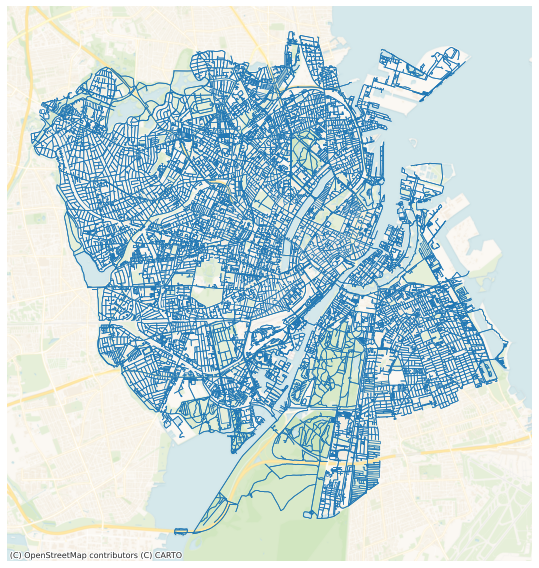

In [3]:
f, ax = plt.subplots(figsize=(8,8))
edges.plot(
    linewidth=.75,
    ax=ax
)
cx.add_basemap(
    source=cx.providers.CartoDB.VoyagerNoLabels,
    crs=edges.crs,
    ax=ax
)
ax.set_axis_off()
plt.tight_layout()
#f.savefig('../pictures/figures/basenetwork.png')

### Bird attributes
Bird data is extracted in the [`bird-edges.ipynb`](/notebooks/bird-edges.ipynb) notebook. Birds are attributed to an edge if a 50m buffer around the bird intersects with a given street.

In [4]:
birds = pd.read_csv('../data/bird_edges.csv').set_index(['u', 'v', 'key'])
birds.head()

birds  birds_per_m
u          v          key                    
118725     298795432  0      8.0     0.070877
           6357644306 0      3.0     0.074080
298795432  298795496  0      7.0     0.077950
6357644306 2378383724 0      2.0     0.091199
           6357644350 0      1.0     0.043373

### Tree attributes
Tree data is extracted in the [`tree-edges.ipynb`](/notebooks/tree-edges.ipynb) notebook. Trees are assigned to the nearest road with a maximum distance of 10m. Each tree is assigned to at most 1 street.

In [5]:
trees = pd.read_csv('../data/tree_edges.csv').set_index(['u', 'v', 'key'])
trees.head()

trees  trees_per_m
u          v          key                    
118725     298795432  0      0.0          0.0
           6357644306 0      0.0          0.0
298795432  298795496  0      0.0          0.0
6357644306 2378383724 0      0.0          0.0
           6357644350 0      0.0          0.0

### Traffic noise attributes
Noise data is extracted in the `noise-edges.ipynb`. Noise polygons are mapped to individual streets, and unmapped streets are imputed using a random forest regressor.

In [6]:
noise = pd.read_csv('../data/noise_edges.csv').set_index(['u', 'v', 'key'])
noise.head()

weighted_noise  predicted_noise  combined_noise
u          v          key                                                 
118725     298795432  0         64.385753              NaN       64.385753
           6357644306 0         68.661369              NaN       68.661369
298795432  298795496  0         62.504355              NaN       62.504355
6357644306 2378383724 0         68.322808              NaN       68.322808
           6357644350 0         68.269927              NaN       68.269927

### Putting it all together
Once all the individual data parts are loaded, they are joined into a single dataframe.

In [7]:
gdf = edges
gdf = gdf.merge(birds, right_index=True, left_index=True, how='left')
gdf = gdf.merge(trees, right_index=True, left_index=True, how='left')
gdf = gdf.merge(noise, right_index=True, left_index=True, how='left')

In [8]:
gdf.head()

osmid  oneway              name   highway  \
u          v          key                                                  
118725     298795432  0     27226011    True  Banegårdspladsen  tertiary   
           6357644306 0    140412993    True     Vesterbrogade  tertiary   
298795432  298795496  0    244360867    True  Banegårdspladsen  tertiary   
6357644306 2378383724 0    678991574    True     Vesterbrogade  tertiary   
           6357644350 0    679140293    True     Vesterbrogade  tertiary   

                          maxspeed   length  \
u          v          key                     
118725     298795432  0         30  112.872   
           6357644306 0         50   40.497   
298795432  298795496  0         30   89.801   
6357644306 2378383724 0         50   21.930   
           6357644350 0         50   23.056   

                                                                    geometry  \
u          v          key                                                      
118725     298795432  0    LINESTRING (724025.025 6175551.339, 724031.889...   
           6357644306 0    LINESTRING (724025.025 6175551.339, 724051.956...   
298795432  298795496  0    LINESTRING (724075.369 6175450.104, 724076.732...   
6357644306 2378383724 0    LINESTRING (724059.919 6175572.112, 724075.704...   
           6357644350 0    LINESTRING (724059.919 6175572.112, 724081.508...   

                          lanes bridge  ref  ... access tunnel junction birds  \
u          v          key                    ...                                
118725     298795432  0     NaN    NaN  NaN  ...    NaN    NaN      NaN   8.0   
           6357644306 0       2    NaN  NaN  ...    NaN    NaN      NaN   3.0   
298795432  298795496  0     NaN    NaN  NaN  ...    NaN    NaN      NaN   7.0   
6357644306 2378383724 0       2    NaN  NaN  ...    NaN    NaN      NaN   2.0   
           6357644350 0       1    NaN  NaN  ...    NaN    NaN      NaN   1.0   

                          birds_per_m  trees  trees_per_m  weighted_noise  \
u          v          key                                                   
118725     298795432  0      0.070877    0.0          0.0       64.385753   
           6357644306 0      0.074080    0.0          0.0       68.661369   
298795432  298795496  0      0.077950    0.0          0.0       62.504355   
6357644306 2378383724 0      0.091199    0.0          0.0       68.322808   
           6357644350 0      0.043373    0.0          0.0       68.269927   

                           predicted_noise  combined_noise  
u          v          key                                   
118725     298795432  0                NaN       64.385753  
           6357644306 0                NaN       68.661369  
298795432  298795496  0                NaN       62.504355  
6357644306 2378383724 0                NaN       68.322808  
           6357644350 0                NaN       68.269927  

[5 rows x 22 columns]

## Algorithm for finding the best "hygge" path
While there are many applicable approaches for this sort of specialized shortest path algorithm, we demonstrate one of the simplest implementations. The implemented approach categorizes each feature, and boosts or penalizes the road length according to a manually set factor, based on how _hyggelig_ we deem the feature to be. For instance, if a path contains a lot of bird observations, we shorten the length of the path to encourage bikers to use it. However, if there is a lot of traffic noise at a path, we lengthen the path by some factor to discourage it. 

$$
d_{hygge} = d \prod_{i=1}^{|w|} w_i
$$

For this, we will use information about birds, trees, noise, and general OSM data.

### Weighting birds


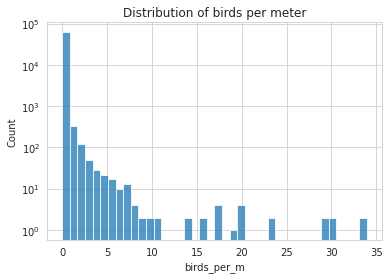

In [9]:
f, ax = plt.subplots()
sns.histplot(data=gdf, x='birds_per_m', ax=ax, bins=40)
ax.set_yscale('log')
ax.set_title('Distribution of birds per meter');

In [10]:
bins = [0, 0.8, 0.9, 1]
labels = ['no birds?', 'some birds', 'HOLY SHIT THAT IS A LOT OF BIRDS']
w_map = {
    'no birds?': 1,
    'some birds': 0.9, 
    'HOLY SHIT THAT IS A LOT OF BIRDS': 0.8
}
gdf['birds_per_m_cat'] = pd.cut(gdf.birds_per_m, gdf.birds_per_m.quantile(bins), include_lowest=True, labels=labels)
gdf['birds_per_m_w'] = gdf.birds_per_m_cat.map(w_map).astype(float)

### Weighting trees

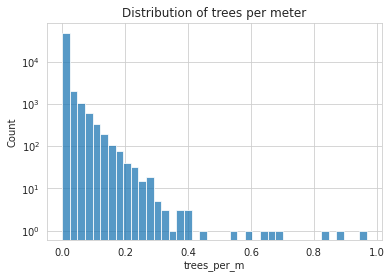

In [11]:
f, ax = plt.subplots()
sns.histplot(data=gdf, x='trees_per_m', ax=ax, bins=40)
ax.set_yscale('log')
ax.set_title('Distribution of trees per meter');

In [12]:
bins = [0, 0.9, 1]
labels = ['no trees?', 'HOLY SHIT THAT IS A LOT OF TREES']
w_map = {
    'no trees?': 1,
    'HOLY SHIT THAT IS A LOT OF TREES': 0.8
}
gdf['trees_per_m_cat'] = pd.cut(gdf.trees_per_m, gdf.trees_per_m.quantile(bins), include_lowest=True, labels=labels)
gdf['trees_per_m_w'] = gdf.trees_per_m_cat.map(w_map).astype(float)

Since we don't know anything about Frederiksberg, we will impute weigth score of 1 for all null values. This might be unfair to Frederiksberg considering they mostl likely have an above average number of trees, but that is outside the scope of this project. For further development, one could try to impute the values based on nearest neighbors or other machine learning algorithms, but we will not in the interest of focusing on the core of this project.

In [13]:
gdf['trees_per_m_w'] = gdf['trees_per_m_w'].fillna(1) 

### Weighting noise

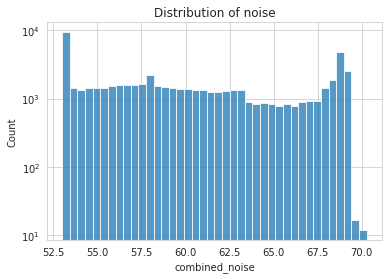

In [14]:
f, ax = plt.subplots()
sns.histplot(data=gdf, x='combined_noise', ax=ax, bins=40)
ax.set_yscale('log')
ax.set_title('Distribution of noise');

In [15]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['mmmm inner peace', 'wow this is pleasant', 'mid', 'hmmm thats pretty loud', 'OUCH MY EARS HURT']
w_map = {
    'mmmm inner peace': 0.8,
    'wow this is pleasant': 0.9,
    'mid': 1,
    'hmmm thats pretty loud': 1.1,
    'OUCH MY EARS HURT': 1.2
}
gdf['noise_cat'] = pd.cut(gdf.combined_noise, gdf.combined_noise.quantile(bins), include_lowest=True, labels=labels)
gdf['noise_w'] = gdf.noise_cat.map(w_map).astype(float)

### Weighting OSM data 

<AxesSubplot:>

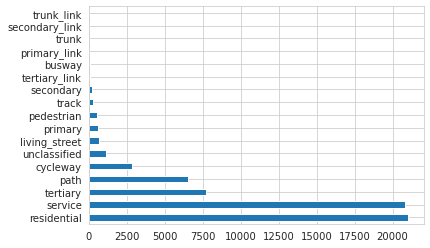

In [16]:
gdf['highway'].value_counts().plot.barh()

In [17]:
w_map = {
    'cycleway':  0.8,
    'track':  0.8,
    'living_street':  0.85,
    'pedestrian':  0.85,
    'service':  0.9,
    'residential':  0.9,
    'path':  1,
    'unclassified':  1,
    'tertiary':  1.1,
    'tertiary_link':  1.1,
    'secondary_link':  1.15,
    'secondary':  1.15,
    'primary_link':  1.2,
    'primary':  1.2,
    'busway':  1.2,
    'trunk':  1.2,
    'trunk_link':  1.2
}
gdf['highway_w'] = gdf.highway.map(w_map)

### Modified hygge length
Now, we can calculate a new hygge length based on the previously defined weights.

In [18]:
gdf['w'] = gdf['birds_per_m_w'] * gdf['trees_per_m_w'] * gdf['noise_w'] * gdf['highway_w']
gdf['hyggelength'] = gdf['length'] * gdf['w']
G = ox.graph_from_gdfs(nodes, gdf)

## Individual hygge paths
On this new graph with hyggelength, we can do standard shortest path computation but with the new hyggelength, resulting in the best hyggepath.

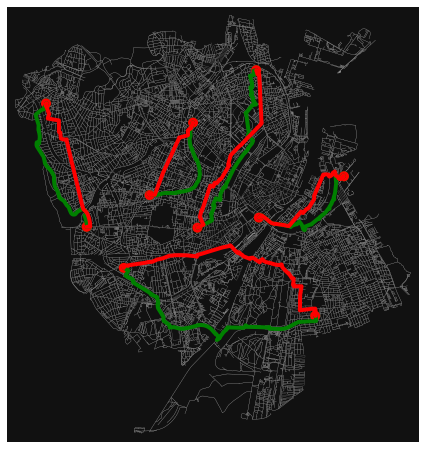

Route from 1632453764 to 8089128 (hygge)
hygge : 5179.3521364
length: 6631.915000000003

Route from 1632453764 to 8089128 (length)
hygge : 6921.840683200001
length: 6083.616999999999

Route from 298629942 to 6117851027 (hygge)
hygge : 3455.5669894
length: 4528.053999999999

Route from 298629942 to 6117851027 (length)
hygge : 4213.2248382
length: 4173.8369999999995

Route from 3903388174 to 976512194 (hygge)
hygge : 3921.901615200001
length: 5552.109999999999

Route from 3903388174 to 976512194 (length)
hygge : 5188.1481516
length: 4707.904999999999

Route from 5434288601 to 450792743 (hygge)
hygge : 6764.102809999997
length: 8312.069000000001

Route from 5434288601 to 450792743 (length)
hygge : 8487.221326
length: 8220.053

Route from 6551516283 to 11806513465 (hygge)
hygge : 2884.7175465000005
length: 3887.8240000000005

Route from 6551516283 to 11806513465 (length)
hygge : 3689.2214004
length: 3073.451999999999



<Figure size 432x288 with 0 Axes>

In [19]:
od_list = [
    (1632453764, 8089128),     # Søerne
    (298629942, 6117851027),   # Christianshavn
    (3903388174, 976512194),   # Damhussøen
    (5434288601, 450792743),   # Valby -> Amager
    (6551516283, 11806513465)  # Grønne Sti
]

routes = []
route_colors = []
route_labels = []
for (orig, dest) in od_list:
    # find shortest path in terms of length and hyggelength
    route_hygge = ox.shortest_path(G, orig, dest, weight='hyggelength')
    route_length = ox.shortest_path(G, orig, dest, weight='length')

    routes += [route_hygge, route_length]
    route_colors += ['green', 'red']
    route_labels += [f"Route from {orig} to {dest} (hygge)", f"Route from {orig} to {dest} (length)"]
    

f, ax = ox.plot_graph_routes(
    G, 
    routes, 
    node_alpha=0, 
    edge_linewidth=0.2,
    route_alpha=1,
    route_colors=route_colors
)
plt.tight_layout()
f.savefig('../pictures/figures/selected_routes.png', bbox_inches='tight')


for route, label in zip(routes, route_labels):
    print(label)
    print('hygge :', nx.path_weight(G, route, weight='hyggelength'))
    print('length:', nx.path_weight(G, route, weight='length'))
    print()

We can repeat this procedure for many combinations of sources and destinations to see how the hygge factors impacts the chosen path lengths.

In [20]:
# Make routes directory if it doesn't exist.
!mkdir -p ../pictures/routes

In [21]:
PLOT = False
N = 10000
random.seed(42)

table_data = []

for n in range(N):
    # set origin and destination
    orig = random.choice(list(G.nodes()))
    dest = random.choice(list(G.nodes()))

    # find shortest path in terms of length and hyggelength
    try:
        route_hygge = nx.shortest_path(G, orig, dest, weight='hyggelength')
        length_hygge = nx.path_weight(G, route_hygge, weight='length')
        hyggelength_hygge = nx.path_weight(G, route_hygge, weight='hyggelength')

        route_length = nx.shortest_path(G, orig, dest, weight='length')
        length_length = nx.path_weight(G, route_length, weight='length')
        hyggelength_length = nx.path_weight(G, route_length, weight='hyggelength')

        # plot the routes
        if PLOT:
            routes = [route_hygge, route_length]
            route_labels = ['hygge path', 'length path']
            f, ax = ox.plot_graph_routes(
                G, 
                routes, 
                node_alpha=0, 
                edge_linewidth=0.2,
                route_colors=['green', 'red']
            )
            f.savefig(f'../pictures/routes/{orig}_{dest}.png')

        table_data.append([orig, dest, length_hygge, length_length, hyggelength_hygge, hyggelength_length, route_hygge, route_length])
    except nx.NetworkXNoPath:
        continue

We format the shortest paths into a dataframe

In [22]:
samples = pd.DataFrame(table_data, columns=['orig', 
                                            'dest', 
                                            'length_hygge', 
                                            'length_length', 
                                            'hyggelength_hygge', 
                                            'hyggelength_length', 
                                            'hygge_route', 
                                            'length_route'])
samples.head()

orig        dest  length_hygge  length_length  hyggelength_hygge  \
0  6443688151  1342608274      7812.298       7412.724        6649.458206   
1  2402868685  4931570324      4431.032       4340.549        3990.511404   
2   291610687  5282649699      8121.093       7464.963        6202.188770   
3  1413992350  9865460414      1102.362       1097.332        1125.097286   
4  4684360834  1374682548      1730.899       1730.611        1481.515791   

   hyggelength_length                                        hygge_route  \
0         7944.955032  [6443688151, 6443688150, 1607386455, 160738647...   
1         4934.037060  [2402868685, 1153588532, 697775, 3100571356, 3...   
2         7814.080378  [291610687, 1524382455, 18164859, 4927487166, ...   
3         1174.788780  [1413992350, 300375597, 11602227456, 8538462, ...   
4         1599.144555  [4684360834, 4684360844, 4729746377, 530742001...   

                                        length_route  
0  [6443688151, 6443688150, 1607386455, 160738647...  
1  [2402868685, 1153588532, 697775, 3100571356, 3...  
2  [291610687, 1524382455, 18164859, 4927487166, ...  
3  [1413992350, 300375597, 11602227456, 8538462, ...  
4  [4684360834, 4684360844, 4729746377, 530742001...

With this dataframe, we can inspect the relationship between the length of hygge paths vs shortest paths. 

In [23]:
samples['reroute_index'] = samples.length_hygge / samples.length_length
samples['hygge_index'] = samples.hyggelength_hygge / samples.hyggelength_length

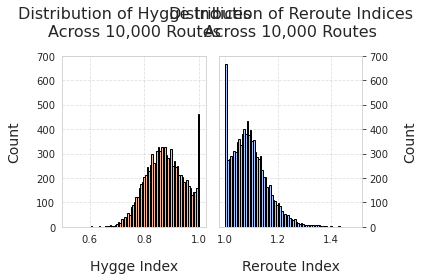

In [24]:
# Define a color palette
palette = sns.color_palette("coolwarm", 2)

# Plot for reroute index
f, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(samples.hygge_index, bins=80, color=palette[1], edgecolor='black')
ax1.set_xlim(0.5, 1.025)
ax1.set_ylim(0, 700)
ax1.set_xlabel('Hygge Index', fontsize=14, labelpad=15)
ax1.set_ylabel('Count', fontsize=14, labelpad=15)
ax1.set_title('Distribution of Hygge Indices\nAcross 10,000 Routes', fontsize=16, pad=20)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2.hist(samples.reroute_index, bins=80, color=palette[0], edgecolor='black')
ax2.set_xlim(0.975,1.52)
ax2.set_ylim(0, 700)
ax2.set_xlabel('Reroute Index', fontsize=14, labelpad=15)
ax2.set_ylabel('Count', fontsize=14, labelpad=15)
ax2.set_title('Distribution of Reroute Indices\nAcross 10,000 Routes', fontsize=16, pad=20)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.tight_layout()
# f.savefig('../pictures/figures/reroute_dist.png')

## Aggregate hygge paths
We also analyse how the edge weights affect the network structure.
Plotting each edge weight show how different paths are being boosted or penalized based on the hygge factors.

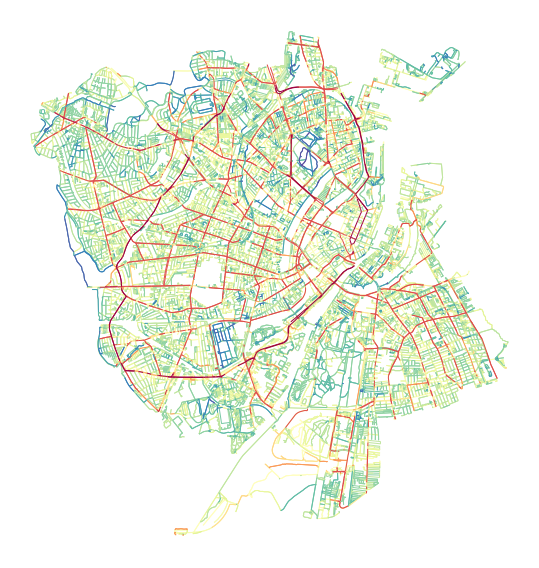

In [25]:
f, ax = plt.subplots(figsize=(8,8))

norm = TwoSlopeNorm(vmin=gdf['w'].min(), vcenter=1, vmax=gdf['w'].max())

gdf['w_abs_diff'] = (1 - gdf['w']).abs()  # abs difference for plotting order

gdf.sort_values('w_abs_diff').plot(
    column='w', 
    cmap='Spectral_r',
    norm=norm,
    linewidth=1,
    ax=ax)
ax.set_axis_off()
plt.tight_layout()
# f.savefig('../pictures/figures/hyggeweights.png')

The above plot is a composite result of all the individual hygge factors. Inspecting all of them individually, we gain a better understanding of the final network weights. 

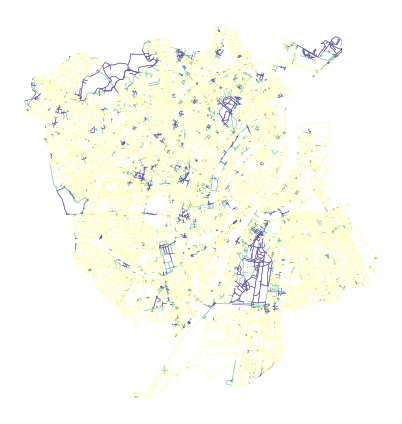

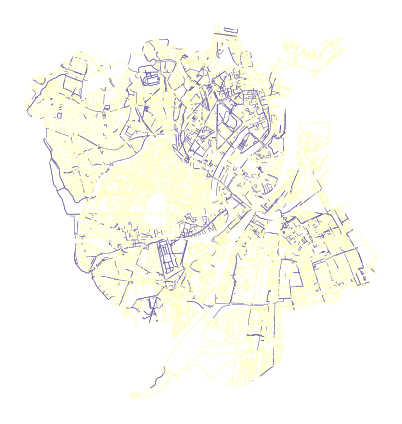

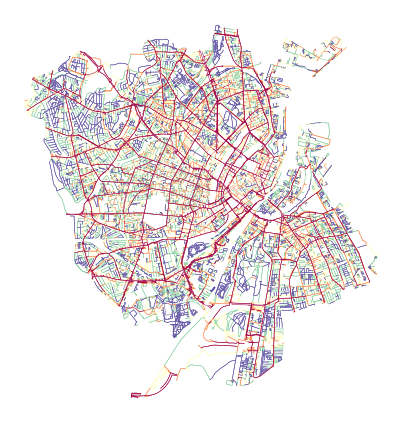

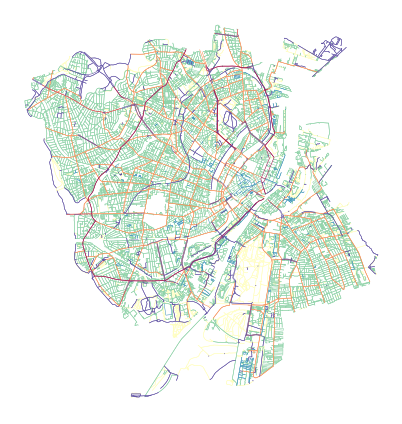

In [26]:
weight_cols = ['birds_per_m_w', 'trees_per_m_w', 'noise_w', 'highway_w']
norm = TwoSlopeNorm(vmin=0.8, vcenter=1, vmax=1.2)

for col in weight_cols:
    f, ax = plt.subplots(figsize=(6,6))
    gdf['sort_value'] = (1 - gdf[col]).abs()
    gdf.sort_values('sort_value').plot(
        column=col,
        cmap='Spectral_r',
        norm=norm,
        linewidth=0.5,
        ax=ax)
    ax.set_axis_off()
    plt.tight_layout()
    # f.savefig(f'../pictures/figures/small_{col}_network.png')

We compute the betweenness of both the original graph and with the hyggelength to compare how network changes with the reweighted paths.

In [27]:
b_length = nx.edge_betweenness_centrality(G, weight='length', k=1000)
b_hygge = nx.edge_betweenness_centrality(G, weight='hyggelength', k=1000)

nx.set_edge_attributes(G, b_length, name='b_length')
nx.set_edge_attributes(G, b_hygge, name='b_hygge')

Subtracting the two betweenness centralities shows exactly how much more or less important individual paths become with regards to routing as we consider our hygge features.

In [28]:
n, e = ox.graph_to_gdfs(G)
e['b_diff'] = e['b_hygge'] - e['b_length']
e['b_diff_abs'] = e['b_diff'].abs()  # absolute value for sorting when plotting

We define a shared scheme for `alpha` and `linewidth` such that plots share the same thresholds. Additionally, we compute bins with fisherjenks to find natural breaks in the data for maximum visual clarity.

In [29]:
# compute bins
fisherjenks = mapclassify.FisherJenks(e['b_length'], 5)
bins = fisherjenks.bins

# define values for alpha and linewidth
alpha_map = {0: 0.4, 1: 0.6, 2: 0.7, 3: 0.85, 4: 1}
linewidth_map = {0: 1, 1: 1.5, 2: 2, 3: 3, 4: 4}

For the color scheme, we create a custom viridis modification, where the yellow is substituted for grey.

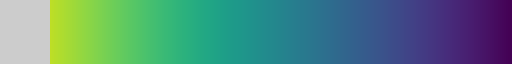

In [30]:
# colormap to alter
viridis_r = plt.cm.get_cmap('viridis_r')

colors = viridis_r(np.linspace(0, 1, 256))  # extract colors from map
yellow_index = int(0.1 * 256)  # index where yellow stops
colors[:yellow_index] = (.8, .8, .8, 1)  # replace the yellow part with new color
viridis_custom = mcolors.LinearSegmentedColormap.from_list('viridis_custom', colors)  # create new cmap
viridis_custom

Now, we can plot both betweenness plots.

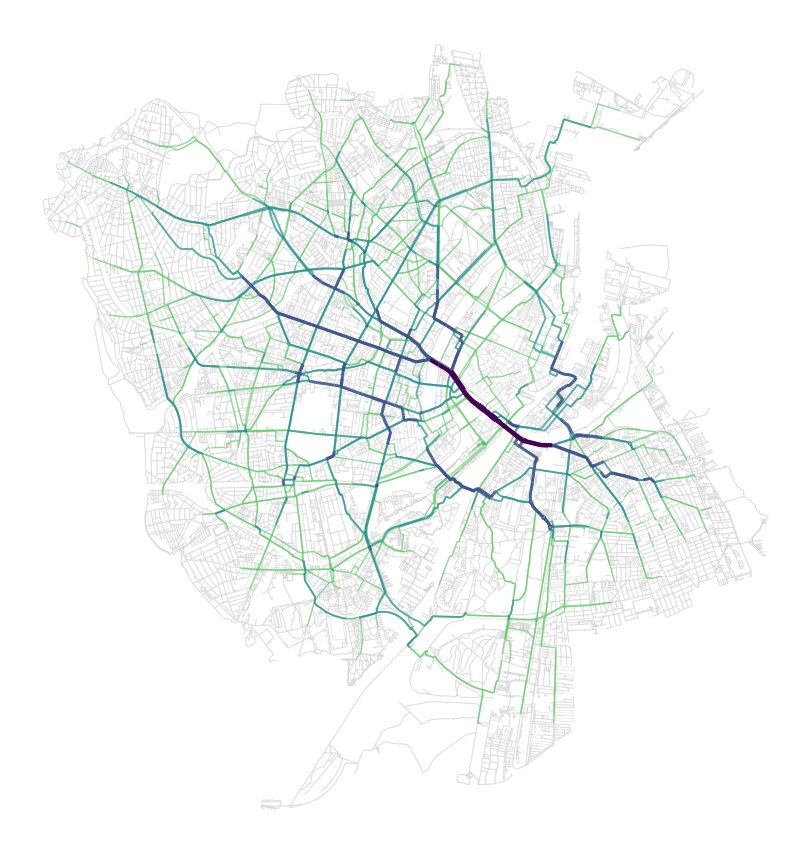

In [31]:
# sort for better line order
e = e.sort_values('b_length')

# apply bins
e['b_length_binned'] = pd.cut(e['b_length'], bins=[-float('inf')] + list(bins), labels=False)

# compute alpha and linewidth
linewidths = e.b_length_binned.map(linewidth_map)
alphas = e.b_length_binned.map(alpha_map)

# make plot
f, ax = plt.subplots(figsize=(12, 12))
e.plot(
    column='b_length_binned', 
    cmap=viridis_custom,
    linewidth=linewidths, 
    alpha=alphas, 
    ax=ax
)
ax.set_axis_off()
plt.tight_layout()
# f.savefig('../pictures/figures/normal_betweenness.png')

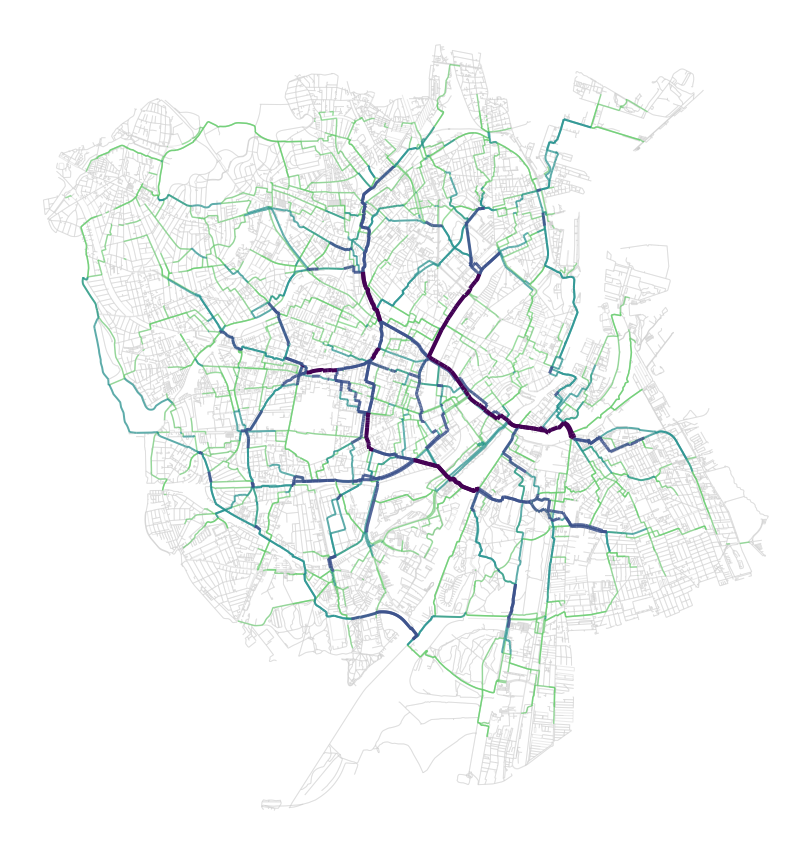

In [32]:
# sort for better line order
e = e.sort_values('b_hygge')

# apply bins
e['b_hygge_binned'] = pd.cut(e['b_hygge'], bins=[-float('inf')] + list(bins), labels=False)

# compute alpha and linewidth
linewidths = e.b_hygge_binned.map(linewidth_map)
alphas = e.b_hygge_binned.map(alpha_map)

# make plot
f, ax = plt.subplots(figsize=(12, 12))
e.plot(
    column='b_hygge_binned', 
    cmap=viridis_custom,
    linewidth=linewidths, 
    alpha=alphas, 
    ax=ax
)
ax.set_axis_off()
plt.tight_layout()
# f.savefig('../pictures/figures/hygge_betweenness.png')

When visualizing the difference in betweenness, it becomes evident which paths become increasingly important to the network structure as we factor in hygge.

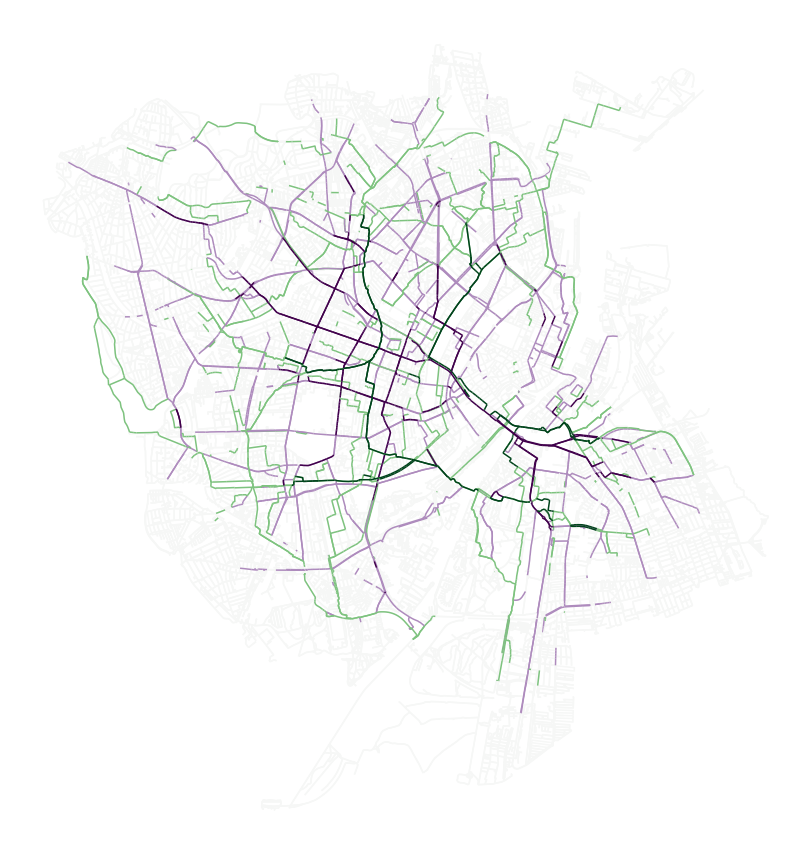

In [33]:
f, ax = plt.subplots(figsize=(12,12))

e.sort_values('b_diff_abs').plot(  # sort for better plotting order
    column='b_diff', 
    scheme='fisherjenks', 
    cmap='PRGn', 
    linewidth=1.5, 
    ax=ax,
)
ax.set_axis_off()

plt.tight_layout()
# f.savefig('../pictures/figures/betweenness_diff.png')

### Extra hygge hygge analysis

#### Clustering of hygge paths
Using all the different hygge features, we can cluster paths that are similar in the hygge dimension.

In [34]:
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['highway'])
], remainder='passthrough', sparse_threshold=0)

pipeline = Pipeline([
    ('onehot', ct),
    ('standard', StandardScaler())
])
X = pipeline.fit_transform(gdf[['highway', 'birds_per_m', 'trees_per_m', 'combined_noise']])

mask = ~np.any(np.isnan(X), axis=1)
X = X[mask]

In [35]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X)

In [36]:
tsne = TSNE(random_state=42)
X_2d = tsne.fit_transform(X)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


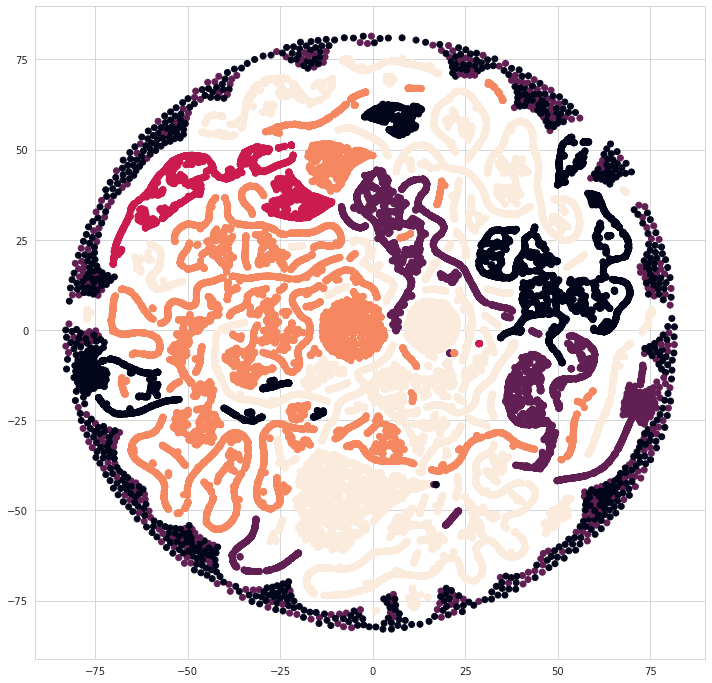

In [37]:
f, ax = plt.subplots(figsize=(12,12))
ax.scatter(X_2d[:,0], X_2d[:,1], c=clusters)

In [38]:
xgdf = gdf[mask]
xgdf['cluster'] = clusters

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


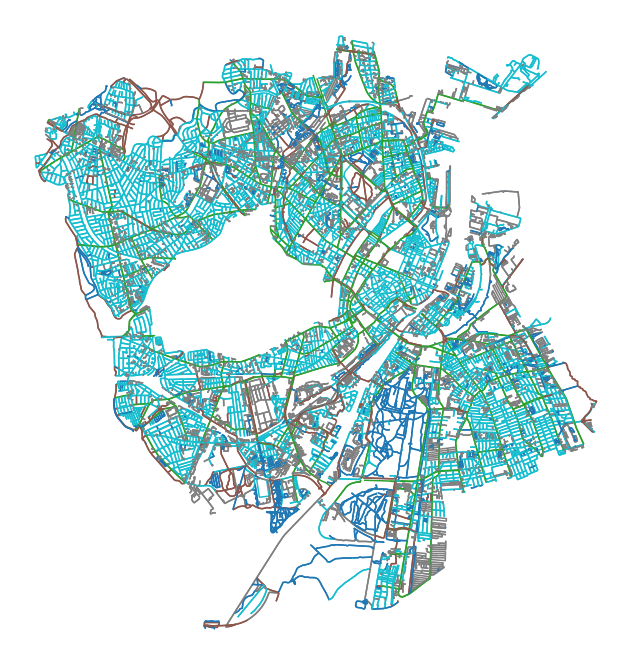

In [39]:
f, ax = plt.subplots(figsize=(12,12))
xgdf.plot(column='cluster', ax=ax, cmap='tab10')
ax.set_axis_off()

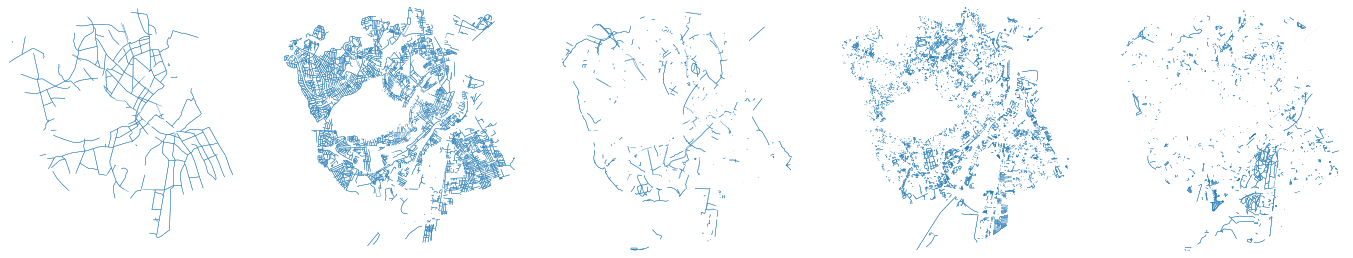

In [40]:
unique_clusters = xgdf.cluster.unique()
N = xgdf.cluster.nunique()

bounds = xgdf.total_bounds

f, axes = plt.subplots(1, N, figsize=(24,24))

for i, c in enumerate(unique_clusters):
    ax = axes[i]
    mask = xgdf.cluster == c
    xgdf[mask].plot(ax=ax, linewidth=0.4)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_axis_off()

In [41]:
silhouette_score(X, clusters)

0.45465250130564794

#### Categorical hygge bike path plot with labeled birds and trees

In [42]:
features = ['birds_per_m', 'trees_per_m']
for feature in features:
    quant = gdf[feature].quantile(0.9)
    gdf[feature + '_cat'] = gdf[feature].apply(lambda x: x > quant)

features_cat = [feature + '_cat' for feature in features]
gdf['super_hygge'] = gdf[features_cat].all(axis=1)

In [43]:
def assign_label(x):
    if x['super_hygge']:
        return 'super_hygge'
    if x['trees_per_m_cat']:
        return 'tree'
    if x['birds_per_m_cat']:
        return 'bird'
    else:
        return 'lortevej'
         
gdf['hygge_cat'] = gdf.apply(assign_label, axis=1)

In [44]:
hygge_alpha = {
    'super_hygge': 1,
    'bird': 0.3,
    'tree': 0.3,
    'lortevej': 0.2
}

hygge_color = {
    'super_hygge': '#c00',
    'bird': '#060',
    'tree': '#00a',
    'lortevej': 'grey'
}

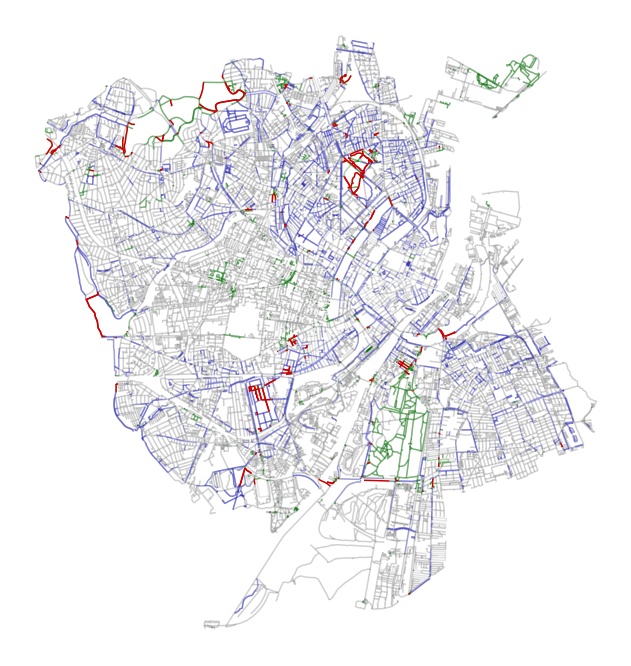

In [45]:
f, ax = plt.subplots(figsize=(12, 12))

for hygge_cat in gdf.hygge_cat.unique():
    gdf[gdf.hygge_cat==hygge_cat].plot(
        color=hygge_color[hygge_cat],
        alpha=hygge_alpha[hygge_cat],
        ax=ax)
ax.set_axis_off()

#### Paths colored by highway

residential red
service yellow
tertiary green
path blue
cycleway orange


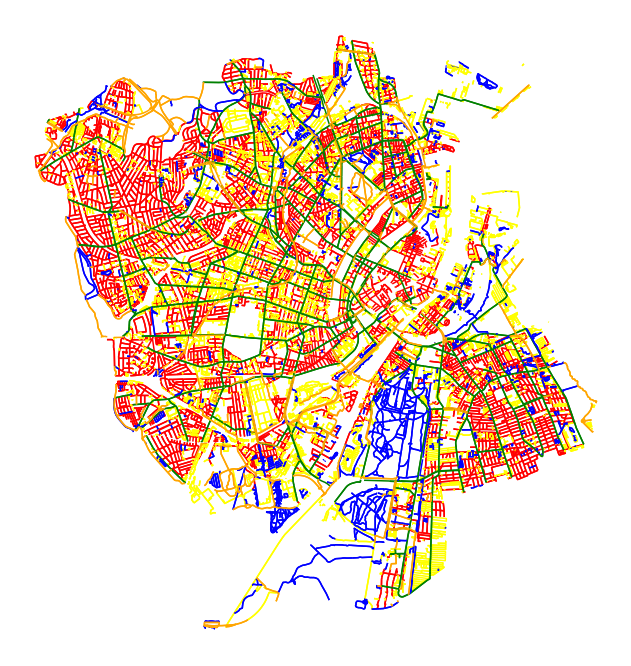

In [46]:
X = gdf
X['highway'] = X.highway.str.split(',').str.join(' ')

f, ax = plt.subplots(figsize=(12,12))
colors = ['red', 'yellow', 'green', 'blue', 'orange']
for i, (key, val) in enumerate(dict(X.highway.value_counts()).items()):
    if i == 5:
        break
    print(key, colors[i])
    X[X.highway == key].plot(ax=ax, color=colors[i], legend=True)
ax.set_axis_off()

#### How to plot a colorbar
```python
f, ax = plt.subplots(figsize=(6,1))
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Add the colorbar to the figure
cbar = f.colorbar(sm, cax=ax, orientation='horizontal')
ax.set_xlabel('Hygge weight', fontdict={'size': 14})

plt.tight_layout()
f.savefig('../pictures/figures/FIGNAME.png')
```